## Model Training and Development
IMBALANCED DATA APPROACHES

- undersample and discard majority class, disadvantage as it may not work well on real data in application
- oversample minority - SMOTE - contained in imblearn library
- using ensemble tree models and adjusting the weights of the classes 

In [196]:
##Setup
import sagemaker
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'sagemakerbankfraud-xgboost'

# Define IAM role

import re
from sagemaker import get_execution_role

role = get_execution_role()

In [197]:
#Import all potential libraries
import boto3
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sklearn
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
import csv
import seaborn as sns
sns.set_style('white')                            #Set theme for Seaborn
import matplotlib.pyplot as plt                   # For charts and visualizations
import sys                                        # For writing outputs to notebook
import os # For manipulating filepath names
%matplotlib inline

In [198]:
###read in preprocessed data from S3
import boto3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'preprocessed/preprocessed.csv')).download_file('preprocessed.csv')

In [199]:
###read in csv file into dataframe
data = pd.read_csv('preprocessedData.csv')
data = data.drop(data.columns[0],1)

In [200]:
###bring in smote library
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
sm = SMOTE()



In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   isfraud         int64  
 1   step            float64
 2   amount          float64
 3   oldbalanceorg   float64
 4   newbalanceorig  float64
 5   oldbalancedest  float64
 6   newbalancedest  float64
 7   morning         float64
 8   afternoon       float64
 9   evening         float64
 10  OrigCust        float64
 11  DestCust        float64
 12  TRANSFER        float64
 13  CASH_OUT        float64
 14  OrigAmountDiff  float64
 15  DestAmountDiff  float64
dtypes: float64(15), int64(1)
memory usage: 776.7 MB


In [9]:
#!pip install scikit-learn==0.23.1
#!pip install imbalanced-learn==0.7.0

In [304]:
###split data into training and validation
train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

In [305]:
test_data.head()

,isfraud,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,morning,afternoon,evening,OrigCust,DestCust,TRANSFER,CASH_OUT,OrigAmountDiff,DestAmountDiff
649918,0,0.045822,0.004994,0.000005,0.0,0.000293,0.006815,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.995009,0.138110
6078014,0,0.696765,0.001860,0.000450,0.0,0.007140,0.007620,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.998430,0.116434
3352247,0,0.339623,0.001216,0.000000,0.0,0.001054,0.001369,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.998784,0.116434
2875453,0,0.304582,0.004456,0.000000,0.0,0.003953,0.005155,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.995544,0.116632
5729113,0,0.536388,0.002475,0.000844,0.0,0.000000,0.000642,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.998069,0.116434


In [203]:
train_data.head()

,isfraud,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,morning,afternoon,evening,OrigCust,DestCust,TRANSFER,CASH_OUT,OrigAmountDiff,DestAmountDiff
4734074,0,0.446092,0.001680,0.001032,0.000000,0.000663,0.001099,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.998985,0.116434
3114157,0,0.316712,0.000382,0.028480,0.034936,0.009415,0.008546,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.119607
4914186,0,0.469003,0.000217,0.003470,0.003767,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.116201
6291553,0,0.893531,0.000092,0.005275,0.006168,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.116335
4391453,0,0.431267,0.001303,0.001308,0.004001,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,0.115032


In [204]:
train_x = train_data.drop('isfraud',1)
train_y = train_data['isfraud']

In [205]:
train_data_smote_x, train_data_smote_y = sm.fit_sample(train_x,train_y.ravel())

In [206]:
print("Before OverSampling, counts of label '1': {}".format(sum(train_data['isfraud'] == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_data['isfraud'] == 0)))

print("Before OverSampling, counts of label '1': {}".format(sum(train_data_smote_y == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_data_smote_y== 0)))

Before OverSampling, counts of label '1': 5742
Before OverSampling, counts of label '0': 4448092 

Before OverSampling, counts of label '1': 4448092
Before OverSampling, counts of label '0': 4448092 



In [12]:
###combine array to dataframe smoted
train_data_smote_x['isfraud'] = train_data_smote_y
first_col = train_data_smote_x.pop('isfraud')
train_data_smote_x.insert(0, 'isfraud', first_col)

In [207]:
train_data_smote_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8896184 entries, 0 to 8896183
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float64
 1   amount          float64
 2   oldbalanceorg   float64
 3   newbalanceorig  float64
 4   oldbalancedest  float64
 5   newbalancedest  float64
 6   morning         float64
 7   afternoon       float64
 8   evening         float64
 9   OrigCust        float64
 10  DestCust        float64
 11  TRANSFER        float64
 12  CASH_OUT        float64
 13  OrigAmountDiff  float64
 14  DestAmountDiff  float64
dtypes: float64(15)
memory usage: 1018.1 MB


In [208]:
train_data_smote_x = train_data

In [209]:
###create csv files as AWS Xgboost requires libSVM or CSV
pd.concat([train_data['isfraud'], train_data.drop(['isfraud'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['isfraud'], validation_data.drop(['isfraud'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

In [210]:
###send to S3 buckets
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [63]:
###correlation analysis of preprocessed data
data.corr().style.background_gradient(cmap ='Greens').set_properties(**{'font-size': '10px'})

,isfraud,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,morning,afternoon,evening,OrigCust,DestCust,TRANSFER,CASH_OUT,OrigAmountDiff,DestAmountDiff
isfraud,1.000000,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,-0.001294,0.001332,-0.000014,nan,0.025697,0.053869,0.011256,0.007023,-0.064948
step,0.031578,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.007798,-0.012925,0.004964,nan,-0.004926,0.006925,-0.012918,-0.020054,-0.032949
amount,0.076688,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.007265,-0.007760,0.000360,nan,0.197444,0.365896,-0.004376,-0.973462,0.223252
oldbalanceorg,0.010154,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.004313,-0.001742,-0.002640,nan,0.189486,-0.081593,-0.200899,0.059834,-0.000201
newbalanceorig,-0.008148,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,0.004396,-0.001874,-0.002593,nan,0.193915,-0.087355,-0.210977,0.062306,0.002138
oldbalancedest,-0.005885,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,0.002231,-0.002096,-0.000176,nan,0.231455,0.130476,0.086028,-0.287250,0.072366
newbalancedest,0.000535,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.004027,-0.003361,-0.000736,nan,0.238315,0.191701,0.093476,-0.457470,0.214395
morning,-0.001294,0.007798,0.007265,0.004313,0.004396,0.002231,0.004027,1.000000,-0.505410,-0.511011,nan,0.008284,0.000659,0.004668,-0.007018,0.007731
afternoon,0.001332,-0.012925,-0.007760,-0.001742,-0.001874,-0.002096,-0.003361,-0.505410,1.000000,-0.483439,nan,-0.007892,-0.002841,-0.002552,0.007016,-0.002649
evening,-0.000014,0.004964,0.000360,-0.002640,-0.002593,-0.000176,-0.000736,-0.511011,-0.483439,1.000000,nan,-0.000542,0.002162,-0.002193,0.000131,-0.005204


## Training XGBoost

In [211]:
###bring in container artifact
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")
display(container)

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1'

In [212]:
###set up training input and  shard by S3Key
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv', distribution= 'ShardedByS3Key')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

In [22]:
###start a training modle - use spot instances to reduce cost of training but also use more than one instance to speed up training
#sagemaker.estimator.Estimator??
print("Training Start time is: "+strftime("%Y-%m-%d-%H-%M-%S", gmtime()))
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge',
                                    use_spot_instances=False,
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    max_wait = None,
                                    sagemaker_session = sess)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)


xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

Training Start time is: 2021-01-06-20-17-17
2021-01-06 20:17:17 Starting - Starting the training job...
2021-01-06 20:17:40 Starting - Launching requested ML instancesProfilerReport-1609964237: InProgress
.........
2021-01-06 20:19:01 Starting - Preparing the instances for training......
2021-01-06 20:20:02 Downloading - Downloading input data...
2021-01-06 20:20:43 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input 

## Tuning

In [23]:
objective_metric_name = 'validation:auc'

In [24]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}

In [25]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3,
                           strategy = 'Bayesian')

In [26]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False,wait=False)

In [27]:
tuner.strategy

'Bayesian'

In [28]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
#HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [32]:
region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = 'sagemaker-xgboost-210106-2029'

In [73]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

20 training jobs have completed


In [74]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2021, 1, 6, 21, 9, 11, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9997699856758118},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2021, 1, 6, 21, 22, 39, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:246778806733:training-job/sagemaker-xgboost-210106-2029-011-a3453505',
 'TrainingJobName': 'sagemaker-xgboost-210106-2029-011-a3453505',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2021, 1, 6, 21, 11, 6, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.7679451075343697',
                          'eta': '0.9991525934421017',
                          'max_depth': '10',
                          'min_child_weight': '4.529222649514955'}}


In [75]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 20
{'lowest': 0.5, 'highest': 0.9997699856758118}


,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
9,1.767945,0.999153,10.0,4.529223,sagemaker-xgboost-210106-2029-011-a3453505,Completed,0.99977,2021-01-06 21:11:06+00:00,2021-01-06 21:22:39+00:00,693.0
6,0.445734,0.066830,7.0,2.386240,sagemaker-xgboost-210106-2029-014-39812b48,Completed,0.99976,2021-01-06 21:24:55+00:00,2021-01-06 21:34:20+00:00,565.0
10,1.163020,0.320960,10.0,4.155039,sagemaker-xgboost-210106-2029-010-ca91260d,Completed,0.99968,2021-01-06 21:08:05+00:00,2021-01-06 21:19:49+00:00,704.0
13,1.994563,0.196712,7.0,6.530108,sagemaker-xgboost-210106-2029-007-c2e6c58a,Completed,0.99965,2021-01-06 20:55:30+00:00,2021-01-06 21:04:59+00:00,569.0
19,0.772658,0.959764,6.0,7.843062,sagemaker-xgboost-210106-2029-001-a1fac33b,Completed,0.99960,2021-01-06 20:32:07+00:00,2021-01-06 20:43:14+00:00,667.0
17,1.132018,0.206445,9.0,7.006186,sagemaker-xgboost-210106-2029-003-49c3492a,Completed,0.99959,2021-01-06 20:32:12+00:00,2021-01-06 20:43:11+00:00,659.0
1,0.027033,0.586952,7.0,7.862749,sagemaker-xgboost-210106-2029-019-70ca1cbf,Completed,0.99955,2021-01-06 21:50:42+00:00,2021-01-06 22:00:35+00:00,593.0
14,1.860507,0.534450,7.0,9.507128,sagemaker-xgboost-210106-2029-006-66175f86,Completed,0.99955,2021-01-06 20:46:39+00:00,2021-01-06 20:56:19+00:00,580.0
11,0.000000,0.586952,7.0,7.862749,sagemaker-xgboost-210106-2029-009-119d57d8,Completed,0.99951,2021-01-06 21:00:31+00:00,2021-01-06 21:11:28+00:00,657.0
7,0.083652,0.832527,10.0,3.137255,sagemaker-xgboost-210106-2029-013-a0a4dfea,Completed,0.99949,2021-01-06 21:22:35+00:00,2021-01-06 21:34:49+00:00,734.0


In [76]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

In [77]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

## HOST and Evaluate

In [213]:
###get best model from tuner
best_model = tuning_job_result.get('BestTrainingJob',None)["TrainingJobName"]
print(best_model)

sagemaker-xgboost-210106-2029-011-a3453505


In [79]:
%%time
import boto3
from time import gmtime, strftime

model_name = f"{best_model}-mod"
print(model_name)

info = sage_client.describe_training_job(TrainingJobName=best_model)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {"Image": container, "ModelDataUrl": model_data}

create_model_response = sage_client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

sagemaker-xgboost-210106-2029-011-a3453505-mod
s3://sagemaker-us-east-1-246778806733/sagemakerbankfraud-xgboost/output/sagemaker-xgboost-210106-2029-011-a3453505/output/model.tar.gz
arn:aws:sagemaker:us-east-1:246778806733:model/sagemaker-xgboost-210106-2029-011-a3453505-mod
CPU times: user 15.9 ms, sys: 269 µs, total: 16.2 ms
Wall time: 462 ms


In [80]:
###set up endpoint autoscaling feature
from time import strftime, gmtime
timestamp = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

model_name = model_name
endpoint_config_name = 'xgboost-model-epc' +timestamp
endpoint_name = 'xgboost-bankfraud'+timestamp

production_variants = [{
    'VariantName':'variant-1',
    'ModelName':model_name,
    'InstanceType':'ml.m5.xlarge',
    'InitialVariantWeight':1,
    'InitialInstanceCount':2,
    
}]

In [81]:
sage_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = production_variants)


{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:246778806733:endpoint-config/xgboost-model-epc2021-01-06-22-04-18',
 'ResponseMetadata': {'RequestId': '37dc2370-96c9-4ec2-bc9b-31a283774b50',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '37dc2370-96c9-4ec2-bc9b-31a283774b50',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '117',
   'date': 'Wed, 06 Jan 2021 22:04:19 GMT'},
  'RetryAttempts': 0}}

In [1]:
deployed = sage_client.create_endpoint(
    EndpointName = endpoint_name,
    EndpointConfigName = endpoint_config_name
)

deployed

NameError: name 'sage_client' is not defined

In [94]:
#print(endpoint_name)
ResourceId='endpoint/'+endpoint_name+'/variant/variant-1'
print(ResourceId)

endpoint/xgboost-bankfraud2021-01-06-22-04-18/variant/variant-1


In [95]:
app = boto3.client('application-autoscaling')

In [96]:
###register a policy once endpoint is created
app.register_scalable_target(
    ServiceNamespace ='sagemaker',
    ResourceId = ResourceId,
    ScalableDimension= 'sagemaker:variant:DesiredInstanceCount',
    MinCapacity=2,
    MaxCapacity=10)

{'ResponseMetadata': {'RequestId': '08123afd-a3a1-4563-9eae-d352bcccfdab',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '08123afd-a3a1-4563-9eae-d352bcccfdab',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Wed, 06 Jan 2021 23:01:03 GMT'},
  'RetryAttempts': 0}}

In [97]:
policy_name ='xgboost-scaling-policy' #name policy

In [98]:
###apply poliy to target 
app.put_scaling_policy(
    PolicyName=policy_name,
    ServiceNamespace = 'sagemaker',
    ResourceId = ResourceId,
    ScalableDimension= 'sagemaker:variant:DesiredInstanceCount',
    PolicyType = 'TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 1000.0,
        'PredefinedMetricSpecification':{
            'PredefinedMetricType':'SageMakerVariantInvocationsPerInstance'},
        'ScaleInCooldown': 60,
        'ScaleOutCooldown': 60
    }
    
)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:246778806733:scalingPolicy:837afba5-89b7-447d-9a88-1c1268e82a76:resource/sagemaker/endpoint/xgboost-bankfraud2021-01-06-22-04-18/variant/variant-1:policyName/xgboost-scaling-policy',
 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/xgboost-bankfraud2021-01-06-22-04-18/variant/variant-1-AlarmHigh-6fa82705-85f8-4ba8-9203-bc96b0e8eb20',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:246778806733:alarm:TargetTracking-endpoint/xgboost-bankfraud2021-01-06-22-04-18/variant/variant-1-AlarmHigh-6fa82705-85f8-4ba8-9203-bc96b0e8eb20'},
  {'AlarmName': 'TargetTracking-endpoint/xgboost-bankfraud2021-01-06-22-04-18/variant/variant-1-AlarmLow-471e44eb-e0a4-46ad-813d-5de65df092ca',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:246778806733:alarm:TargetTracking-endpoint/xgboost-bankfraud2021-01-06-22-04-18/variant/variant-1-AlarmLow-471e44eb-e0a4-46ad-813d-5de65df092ca'}],
 'ResponseMetadata': {'RequestId': 'ff442be5-4dd7-4f24-852d-f9935c440ef9',
  'HTTPStatu

xgb_predictor = tuner.deploy(
    endpoint_name =endpoint_name,
    initial_instance_count = 1, 
    instance_type = 'ml.m5.xlarge',
    serializer=CSVSerializer())

In [214]:
runtime_client = boto3.Session().client('runtime.sagemaker')

In [327]:
###get test data in correct format to invoke endpoint to evaluate
##tested 1000 items
import io
test_data
test_data_tail = test_data.tail(1000)
test_actuals = test_data_tail.pop('isfraud')
#test_data2 = test_data.drop('isfraud',1)

test_data_tail.to_csv('test_data_tail.csv',header =False, index=False)



In [328]:
import time
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

predictions = ''

with open('test_data_tail.csv', 'r') as f:
    for row in f:
        print(".", sep=',', end='', flush=True)
        payload = row.rstrip('\n')
        response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
                                       ContentType="text/csv",
                                       Accept='Accept',
                                       Body=payload)
        predictions = ','.join([predictions, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

#Convert our predictions to a numpy array
pred_np = np.fromstring(predictions[1:], sep=',')
        
#Convert the prediction probabilities to binary predictions of either 1 or 0
threshold = 0.5
preds = np.where(pred_np > threshold, 1, 0)            
        
print("Done!")

Sending test traffic to the endpoint xgboost-bankfraud2021-01-06-22-04-18. 
Please wait...
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,variant-1
Timestamp,
2021-01-07 16:23:00+00:00,1.0
2021-01-07 16:24:00+00:00,1.0
2021-01-07 16:25:00+00:00,2.0
2021-01-07 16:30:00+00:00,11.0
2021-01-07 16:31:00+00:00,11.0
2021-01-07 16:32:00+00:00,11.0
2021-01-07 16:33:00+00:00,1.0
2021-01-07 16:34:00+00:00,10.0
2021-01-07 16:35:00+00:00,10.0


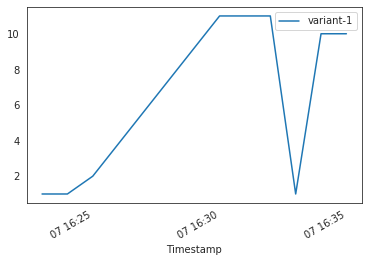

In [313]:
from datetime import datetime, timedelta
import time
import pandas as pd
cw = boto3.Session().client("cloudwatch")
variant = 'variant-1'

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop("Unit", axis=1)\
            .rename(columns={"Sum": variant_name})

def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(endpoint_name, 'variant-1', start_time, end_time)
    metrics_variant1.plot()
    return metrics_variant1

time.sleep(20) #let metrics catch up
plot_endpoint_metrics()

## Evaluation of test Results

In [329]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score

test_actuals = test_actuals.to_numpy()



In [330]:
###set up confusion matrix
df_confusion = pd.crosstab(index=test_actuals, columns=preds, rownames=['actuals'], colnames=['predictions'])
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_conf_norm

predictions,0,1
actuals,,
0,1.0,0.0
1,0.0,1.0


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC is 1.0


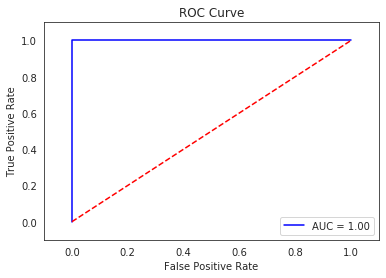

In [337]:
# Calculate accuracy
accuracy = sum(preds == test_actuals) / len(test_actuals)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = sum(preds[preds == 1] == test_actuals[preds == 1]) / len(preds[preds == 1])
print(f'Precision: {precision}')

# Calculate recall
recall = sum(preds[preds == 1] == test_actuals[preds == 1]) / len(test_actuals[test_actuals == 1])
print(f'Recall: {recall}')

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1_score}')

# Calculate AUC
auc = round(roc_auc_score(test_actuals, preds), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(test_actuals, preds)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

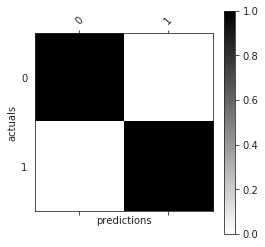

In [338]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

## DETELE ALL ENDPOINTS

In [ ]:
xgb_predictor.delete_endpoint() ###new endpoint created for autoscaling - can delete this one

In [106]:
####to save cost and delete since this is a demo-project
app.delete_scaling_policy(
    PolicyName=policy_name,
    ServiceNamespace = 'sagemaker',
    ResourceId = 'endpoint/xgboost-bankfraud/variant/variant-1',
    ScalableDimension= 'sagemaker:variant:DesiredInstanceCount',
)
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'bba6d8f9-724f-4acd-857a-74b01e6e08a1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bba6d8f9-724f-4acd-857a-74b01e6e08a1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 05 Jan 2021 19:24:10 GMT'},
  'RetryAttempts': 0}}

In [107]:
sm.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': '2f72459a-9b2c-4d1a-82c9-078c181ee6d9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2f72459a-9b2c-4d1a-82c9-078c181ee6d9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 05 Jan 2021 19:24:12 GMT'},
  'RetryAttempts': 0}}